In [53]:
import sqlite3
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score
from sklearn.pipeline import make_pipeline
import matplotlib.pyplot as plt
from sklearn.model_selection import cross_val_score, StratifiedKFold
from sklearn.metrics import confusion_matrix
import seaborn as sns
from sklearn.model_selection import learning_curve

In [54]:

# Prisijungti prie SQLite databazes
conn = sqlite3.connect('documents.db')
cursor = conn.cursor()

# Pasirinkt text ir label
cursor.execute("SELECT text, label FROM documents")
documents = cursor.fetchall()

conn.close()

# Indeksuoti teksta ir labelius
texts = [doc[0] for doc in documents]
labels = [doc[1] for doc in documents]

In [55]:

# Padaliname database i test ir train
X_train, X_test, y_train, y_test = train_test_split(texts, labels, test_size=0.2, random_state=42)


# Sukuriame TfidfVectorizer
vectorizer = TfidfVectorizer()

# Treniruojame TfidfVectorizer
X_train_vectorized = vectorizer.fit_transform(X_train)
X_test_vectorized = vectorizer.transform(X_test)


In [56]:
# Sukuriame parametrus kryžminiam patikrinimui
param_grid = {
    'alpha': [0.1, 0.2, 0.3, 0.5, 0.6, 0.7, 0.8, 1.0],
}

# Apibrėžiame modelį
model = MultinomialNB()

# Vykdome kryžmynį patikrinimą
grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=5, scoring='accuracy')
grid_search.fit(X_train_vectorized, y_train)

# Apibrėžiąme geriausius hyperparametrus
best_params = grid_search.best_params_
print("Geriausi hyperparametrai:", best_params)

Geriausi hyperparametrai: {'alpha': 0.6}


In [57]:
# Treniruojame modelį
model.fit(X_train_vectorized, y_train)

# Vykdome spėjimus
predicted_categories = model.predict(X_test_vectorized)

# Atspausdiname spėjimus (teksto indeksas, tikra kategorija ir spėjama kategorija)
for idx, (text, actual_category, predicted_category) in enumerate(zip(X_test_vectorized, y_test, predicted_categories)):
    print(f"Index: {idx}, Tikra kategorija: {actual_category} Spėjama kategorija: {predicted_category}")

Index: 0, Tikra kategorija: isakymai Spėjama kategorija: isakymai
Index: 1, Tikra kategorija: isakymai Spėjama kategorija: isakymai
Index: 2, Tikra kategorija: potvarkiai Spėjama kategorija: potvarkiai
Index: 3, Tikra kategorija: isakymai Spėjama kategorija: potvarkiai
Index: 4, Tikra kategorija: sprendimai Spėjama kategorija: sprendimai
Index: 5, Tikra kategorija: sprendimai Spėjama kategorija: sprendimai
Index: 6, Tikra kategorija: sprendimai Spėjama kategorija: sprendimai
Index: 7, Tikra kategorija: potvarkiai Spėjama kategorija: potvarkiai
Index: 8, Tikra kategorija: sprendimai Spėjama kategorija: sprendimai
Index: 9, Tikra kategorija: isakymai Spėjama kategorija: isakymai
Index: 10, Tikra kategorija: sprendimai Spėjama kategorija: sprendimai
Index: 11, Tikra kategorija: isakymai Spėjama kategorija: potvarkiai


Accuracy: 83.33%


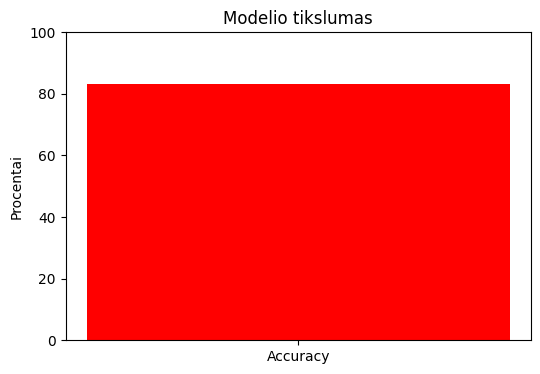

In [58]:
# Tikriname ikslumą
accuracy = accuracy_score(y_test, predicted_categories)
print(f'Accuracy: {accuracy*100:.2f}%')

plt.figure(figsize=(6,4))
plt.bar(['Accuracy'], [accuracy*100], color='red')
plt.ylabel('Procentai')
plt.title('Modelio tikslumas')
plt.ylim(0, 100)
plt.show()

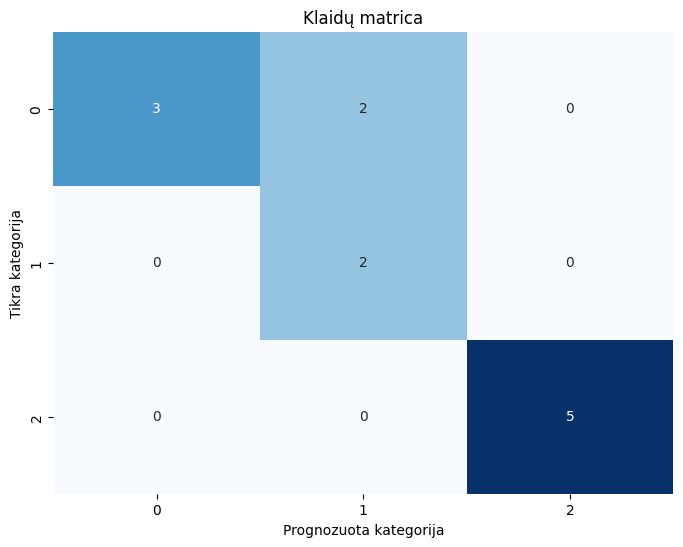

In [59]:

# Klaidu matrica
conf_matrix = confusion_matrix(y_test, predicted_categories)

plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.title('Klaidų matrica')
plt.xlabel('Prognozuota kategorija')
plt.ylabel('Tikra kategorija')
plt.show()

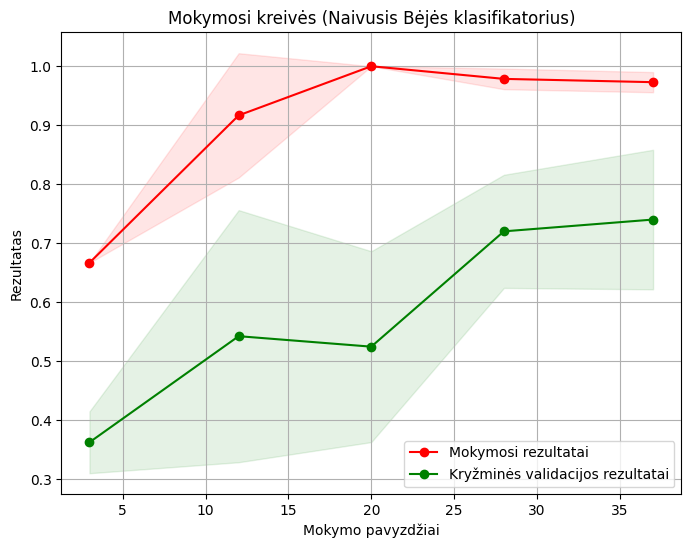

In [60]:
# Learning curve
def plot_learning_curve(estimator, title, X, y, ylim=None, cv=None, n_jobs=None, train_sizes=np.linspace(.1, 1.0, 5)):
    plt.figure(figsize=(8, 6))
    plt.title(title)
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel("Mokymo pavyzdžiai")
    plt.ylabel("Rezultatas")
    train_sizes, train_scores, test_scores = learning_curve(estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    plt.grid()

    plt.fill_between(train_sizes, train_scores_mean - train_scores_std, train_scores_mean + train_scores_std, alpha=0.1, color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std, test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r", label="Mokymosi rezultatai")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g", label="Kryžminės validacijos rezultatai")

    plt.legend(loc="best")
    return plt

title = "Mokymosi kreivės (Naivusis Bėjės klasifikatorius)"
estimator = model
plot_learning_curve(estimator, title, X_train_vectorized, y_train, cv=5, n_jobs=-1)
plt.show()